In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3 
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear') #, align_corners=True
        self.conv3_t = nn.Conv2d(64, 64, 3, 1, 1) # Decoder - 3
        self.conv2_t = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 2
        self.conv1_t = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 1
        self.conv0_t = nn.Conv2d(16, 1, 3, 1, 1) # Final Decoder
        
    def forward(self, x):
        out = self.bn16(F.relu(self.conv1(x)))
        out = self.bn32(F.relu(self.conv2(out)))
        out = self.bn64(F.relu(self.conv3(out)))
        out = self.upsample(self.bn64(F.relu(self.conv3_t(out))))
        out = self.upsample(self.bn32(F.relu(self.conv2_t(out))))
        out = self.upsample(self.bn16(F.relu(self.conv1_t(out))))
        out = torch.tanh(self.conv0_t(out))
        return out

In [3]:
MAX_EPOCHS = 5000

file = 'lena'
im = imread('../data/denoising/{}.png'.format(file))
noise = imread('../data/denoising/{}-noisy.png'.format(file))
noisy_img = torch.FloatTensor(noise).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)

net = EncDec()
criterion, optimizer = nn.MSELoss(), optim.Adam(net.parameters(), lr=0.01)
eta = torch.randn(*noisy_img.size())
training_error, testing_error, runtime_stats = np.zeros((MAX_EPOCHS)), np.zeros((MAX_EPOCHS)), {}

for itr in range(MAX_EPOCHS+1):
    out = net(eta)
    optimizer.zero_grad()
    loss = criterion(out, clean_img)
    loss.backward()
    optimizer.step()
    
    if itr % 100 == 0:
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        curr_error = ((im - out_img)**2).sum()
        print ("Loss = {}, Error = {}".format(loss.detach().numpy().reshape(-1)[0], curr_error))

/home/ec2-user/anaconda3/envs/cs682/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Loss = 0.46093669533729553, Error = 45311.92129181814
Loss = 0.003229897702112794, Error = 317.5118615465655
Loss = 0.009633410722017288, Error = 947.0027790775945
Loss = 0.0018130156677216291, Error = 178.22669732072933
Loss = 0.0016688042087480426, Error = 164.05012789552978
Loss = 0.0035759792663156986, Error = 351.53306199009194
Loss = 0.001158301718533039, Error = 113.86569367717823
Loss = 0.0012159361504018307, Error = 119.53139016499327
Loss = 0.0009239544742740691, Error = 90.82841905300504
Loss = 0.0008704466163180768, Error = 85.56838580358243
Loss = 0.0008818150381557643, Error = 86.68594473536159
Loss = 0.0007522775558754802, Error = 73.95189376303922
Loss = 0.0011080167023465037, Error = 108.92246981435055
Loss = 0.0010821915930137038, Error = 106.38376784786682
Loss = 0.0006529187667183578, Error = 64.1845287382603
Loss = 0.0005996960680931807, Error = 58.95252367952715
Loss = 0.0006564801442436874, Error = 64.53462639655362
Loss = 0.0007825313950888813, Error = 76.925965

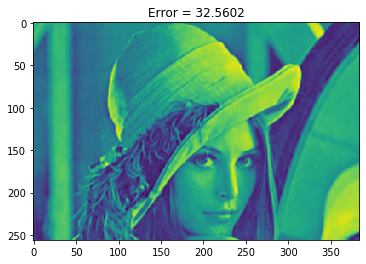

In [5]:
out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
curr_error = ((im - out_img)**2).sum()
plt.title('Error = %.4f' % curr_error )
plt.imshow(out_img)
plt.show()

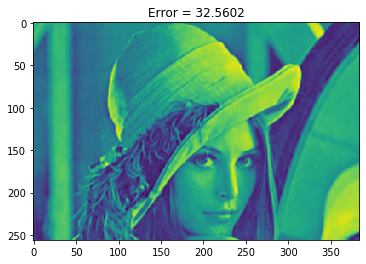

In [4]:
out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
curr_error = ((im - out_img)**2).sum()
plt.title('Error = %.4f' % curr_error )
plt.imshow(out_img)
plt.show()